# Trabalho Final

## Imports

In [29]:
import itertools
import pandas as pd
import numpy as np
import random
from dataclasses import dataclass as dc
from typing import Iterable
from collections import namedtuple
from plotnine import *
from copy import deepcopy
pd.set_option('display.max_colwidth', None)

SyntaxError: invalid syntax (844377037.py, line 8)

## Functions

In [ ]:
Numero = int # Indice da tarefa
intervalo = namedtuple("intervalo", ["inicio", "fim"])
def first(iterable, func, default=None):
  return next(filter(func, iterable), default)

@dc
class Tarefa:
  numero: int
  tempo: int
  def __repr__(self):
    return f"T{self.numero}({self.tempo})"
  def __hash__(self):
    return repr(self).__hash__()
class Tarefas:
  def __init__(self, tempos: list[int]):
    self.tarefas = [Tarefa(i+1, tempos[i]) for i in range(len(tempos))]
  
  def __getitem__(self, i: Numero | Iterable[Numero]):
    if isinstance(i, Iterable):
      return [self.tarefas[i-1] for i in i]
    return self.tarefas[i-1]
  def __iter__(self):
    return iter(self.tarefas)
  def smallest_to_highest(self):
    return sorted(self.tarefas, key=lambda t: t.tempo)

@dc 
class Maquina:
  numero: int
  n_tarefas: int
  tarefas: list[Tarefa] = None

  def __post_init__(self):
    assert self.tarefas is None or len(self.tarefas) <= self.n_tarefas
    if self.tarefas is None: self.tarefas = []
  def assignTarefas(self, tarefas: list[Tarefa]):
    assert len(tarefas) <= self.n_tarefas
    self.tarefas = tarefas
  def queueTarefa(self, tarefa: Tarefa):
    assert len(self.tarefas) < self.n_tarefas # se for igual ent n pode adicionar
    self.tarefas.append(tarefa)
  def reset(self):
    self.tarefas = []
  
  def quantoTempo(self):
    return sum(t.tempo for t in self.tarefas)
  def __repr__(self):
    return f"M{self.numero}({repr(self.tarefas)}, {self.quantoTempo()})"
  def __str__(self):
    return f"M{self.numero}"
  def isTarefaIn(self, tarefa: Tarefa | Numero):
    if isinstance(tarefa, Tarefa):
      return tarefa in self.tarefas
    return tarefa in [t.numero for t in self.tarefas]
  def quandoComeca(self, tarefa: Tarefa | Numero):
    if isinstance(tarefa, Numero):
      tarefa = first(self.tarefas, lambda t: t.numero == tarefa)
    # index of tarefa in self.tarefas
    ind = self.tarefas.index(tarefa)
    return sum(t.tempo for t in self.tarefas[:ind])
  def quandoAcaba(self, tarefa: Tarefa | Numero):
    if isinstance(tarefa, Numero):
      tarefa = first(self.tarefas, lambda t: t.numero == tarefa)
    return self.quandoComeca(tarefa) + tarefa.tempo

class Horario:
  # representa as maquians e as horas que as tarefas começam
  # horario comeca completo, vindo da Permutation.getHorario()
  # Horario.timeOf("M1") -> quando acaba a maquina 1
  # Horario["T1"] -> quando começa e acaba a tarefa 1
  # Horario.whereIs("T1") -> Em que máquina está a tarefa 1
  # nota: isto pode estar dentro do permutation, mas acho melhor assim para dividir funções
  def __init__(self, maquinas: list[Maquina]):
    self.maquinas = maquinas
  def __getitem__(self, tarefa: str | Tarefa) -> intervalo:
    maq = self.whereIs(tarefa)
    if maq is None: raise KeyError(f"Tarefa {tarefa} não está no horário")
    return intervalo(maq.quandoComeca(tarefa), maq.quandoAcaba(tarefa))
  def timeOf(self, maquina: str | Maquina):
    if isinstance(maquina, str):
      maquina = self.getMaquina(maquina)
    return maquina.quantoTempo()
  def getMaquina(self, maquina: str | Numero):
    if isinstance(maquina, str): 
      return first(self.maquinas, lambda m: str(m) == maquina)
    return first(self.maquinas, lambda m: m.numero == maquina)
  def whereIs(self, tarefa: str | Tarefa):
    if isinstance(tarefa, str):
      tarefa = int(tarefa[1:])
    return first(self.maquinas, lambda m: m.isTarefaIn(tarefa))
  def getTempoTotal(self):
    return max(m.quantoTempo() for m in self.maquinas)
  @property
  def tempoTotal(self):
    return self.getTempoTotal()
  def plot(self):
    df = pd.DataFrame({
      "maquina": [m.numero for m in self.maquinas for t in m.tarefas ],
      "tarefa": [t.numero for m in self.maquinas  for t in m.tarefas ],
      "tarefaL": [f"T{t.numero}" for m in self.maquinas  for t in m.tarefas ],
      "comeca": [m.quandoComeca(t)  for m in self.maquinas for t in m.tarefas],
      "acaba": [m.quandoAcaba(t) for m in self.maquinas for t in m.tarefas]
    })
    return ggplot(df, aes(y = "maquina")) + \
      geom_point(aes(x = "comeca", color='factor(tarefa)'), size = 5) + \
      geom_path(aes(x = "acaba", group = "maquina", color="factor(tarefa+1)")) + \
      geom_path(aes(x = "comeca", group = "maquina", color="factor(tarefa)")) + \
      geom_vline(xintercept=self.tempoTotal, linetype="dashed") + \
      geom_text(aes(x = "comeca", label="tarefaL"), size=10, nudge_x=0.1, nudge_y=0.1) + \
      \
      scale_x_continuous(breaks=[0, 24, 48, 72, 96, 120, self.tempoTotal]) + \
      scale_y_continuous(breaks=[1, 2, 3]) + \
      scale_color_discrete(guide=False) + \
      coord_fixed(xlim = (-0.5, 144)) + \
      labs(x="horas", y="maquina") + \
      theme_classic() + \
      theme(aspect_ratio=0.7)
class Permutation:
  # Representação por permutação
  def __init__(self, maquinas: list[Maquina]):
    self.maquinas = maquinas
    self.n_maquinas = len(maquinas)
  def reset(self):
    for m in self.maquinas:
      m.reset()
    return self
  def machineYielder(self):
    for m in self.maquinas:
      for i in range(len(m.tarefas)):
        yield m
  def assignTarefas(self, tarefas: list[Tarefa]):
    self.reset()
    for m in self.machineYielder():
      m.queueTarefa(tarefas.pop(0))
    return self.as_list()
  def as_list(self) -> list[Tarefa]:
    return [t for m in self.maquinas for t in m.tarefas]
  def as_cromo(self) -> list[int]:
    return [t.numero for t in self.as_list()]
  def as_lists(self) -> list[list[Tarefa]]:
    return [m.tarefas for m in self.maquinas]
  def __repr__(self):
    return repr(self.as_lists())
  def getHorario(self) -> Horario:
    return Horario(self.maquinas)
  @property
  def horario(self) -> Horario:
    return self.getHorario()
  def __repr__(self):
    return repr(self.as_list())
M1 = Maquina(
  numero = 1,
  n_tarefas = 4,
)
M2 = Maquina(
  numero = 2,
  n_tarefas = 3,
)
M3 = Maquina(
  numero = 3,
  n_tarefas = 3,
)
M1, M2, M3

(M1([], 0), M2([], 0), M3([], 0))

In [ ]:
tarefas = Tarefas([38, 33, 36, 20, 32, 29, 46, 38, 34, 40])
tarefas[1,2,4]

[T1(38), T2(33), T4(20)]

[T1(38), T2(33), T3(36), T4(20), T5(32), T6(29), T7(46), T8(38), T9(34), T10(40)]


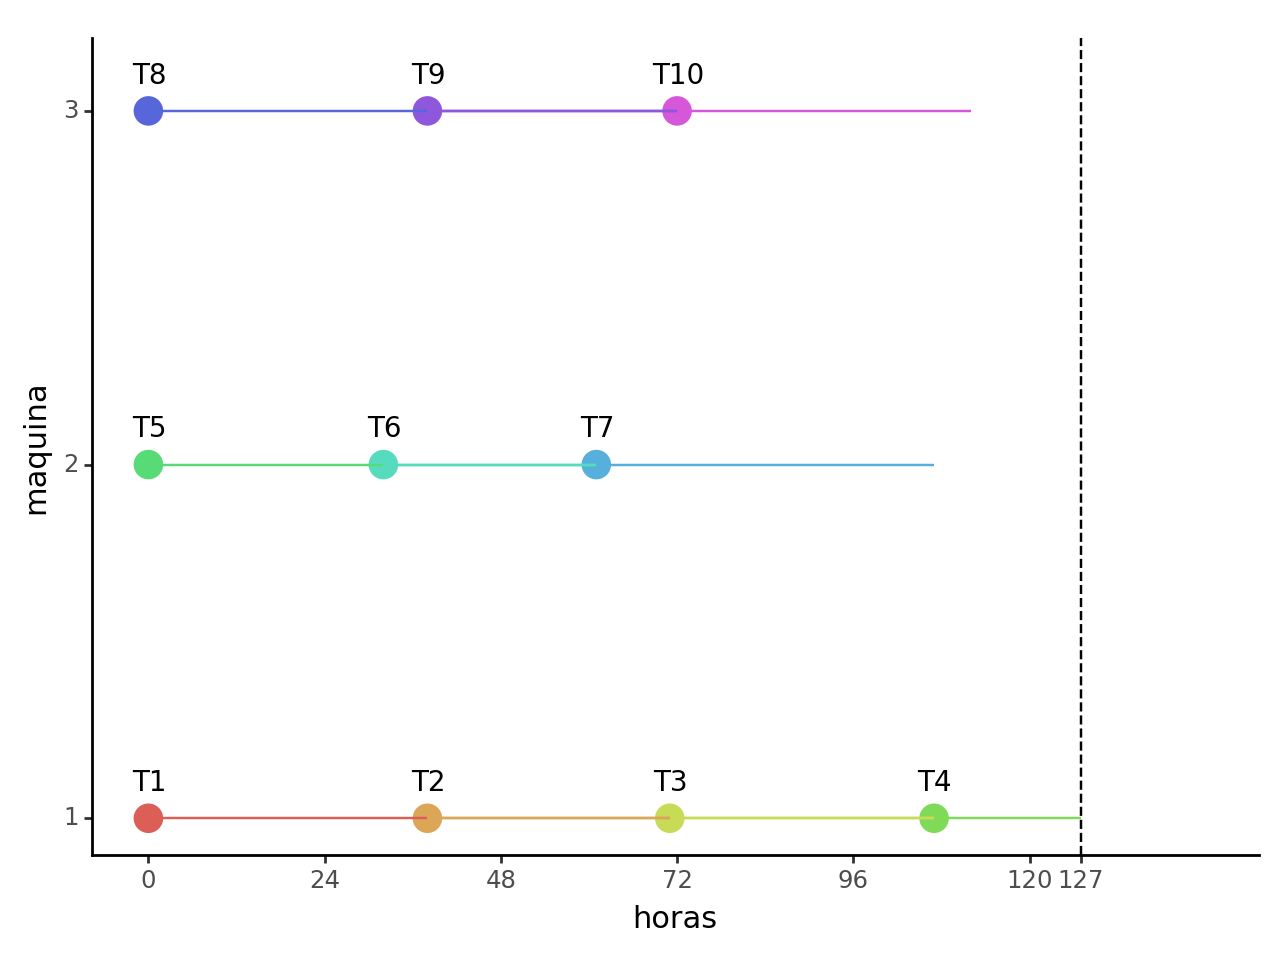

<Figure Size: (640 x 480)>

In [ ]:
# exemplo
M1.assignTarefas(tarefas[1,2,3,4])
M2.assignTarefas(tarefas[5,6,7])
M3.assignTarefas(tarefas[8,9,10])
primeiro = Permutation([M1, M2, M3])
print(primeiro)
primeiro.horario.plot()

In [ ]:
def respeitaRestricao(horario, maximos: dict[Tarefa, int]):
  for tarefa, maximo in maximos.items():
    if horario[tarefa].fim > maximo:
      return False
  return True
acabarAntes = 24*(5-1) # 1 junho (8h) até 5 junho (8h),
restricao = {
  tarefas[3]: acabarAntes,
  tarefas[4]: acabarAntes,
  tarefas[5]: acabarAntes
}
respeitaRestricao(primeiro.horario, restricao)

False

In [ ]:
def create_df(permutations: list[Permutation] | Permutation, *args):
  if isinstance(permutations, Permutation): return create_df([permutations, *args])
  return pd.DataFrame({
    "M1": [p.maquinas[0].tarefas for p in permutations],
    "M2": [p.maquinas[1].tarefas for p in permutations],
    "M3": [p.maquinas[2].tarefas for p in permutations],
    "tempo_total": [p.horario.tempoTotal for p in permutations],
    "respeita_restricao": [respeitaRestricao(p.horario, restricao) for p in permutations],
    "respeita_unique": [len(set(p.as_cromo())) == len(p.as_cromo()) for p in permutations]
  })
# use example
create_df(primeiro)

,M1,M2,M3,tempo_total,respeita_restricao,respeita_unique
0,"[T1(38), T2(33), T3(36), T4(20)]","[T5(32), T6(29), T7(46)]","[T8(38), T9(34), T10(40)]",127,False,True


## Pergunta a)

TODO palavras

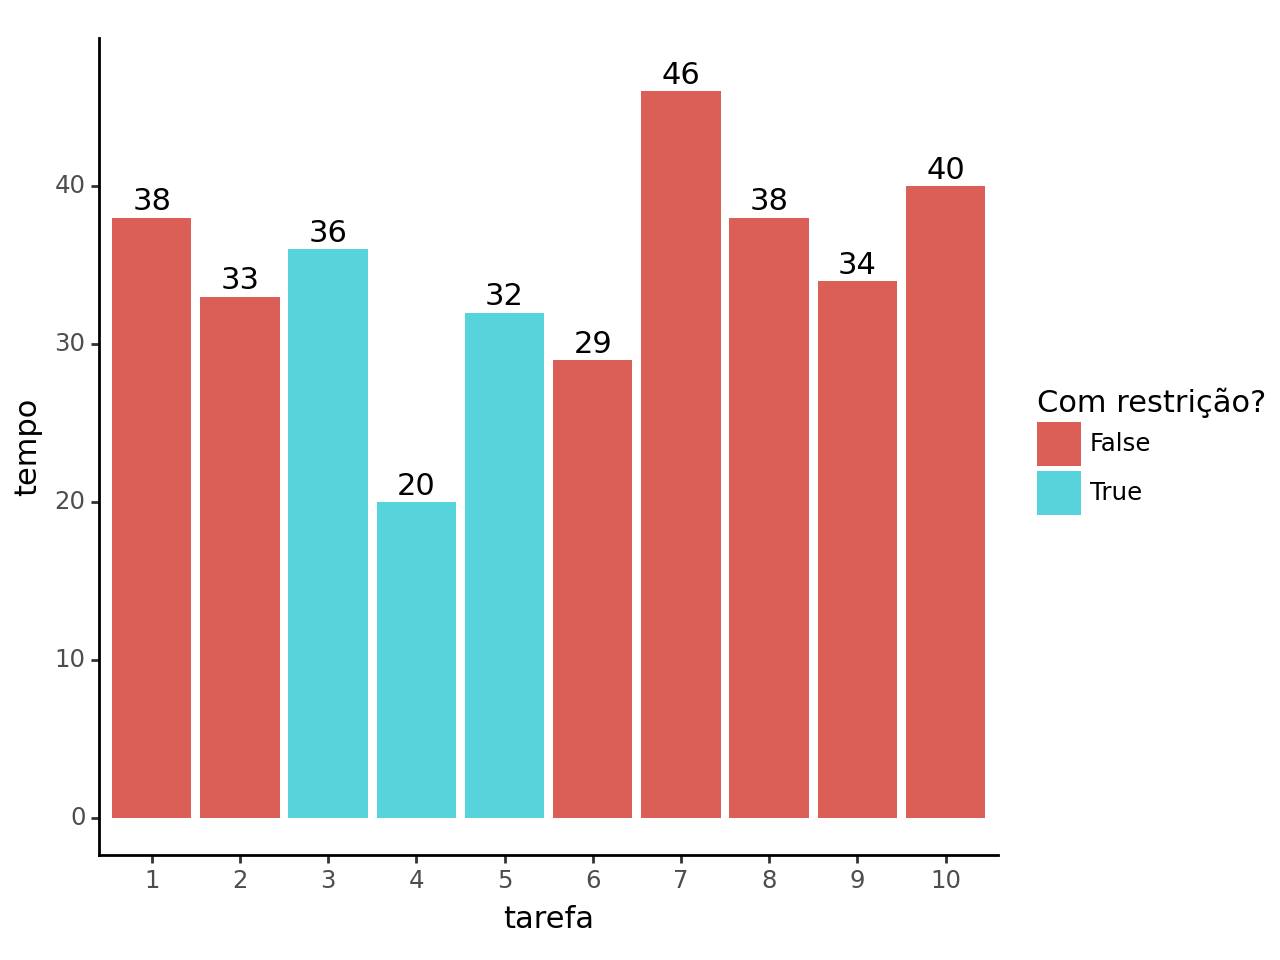

<Figure Size: (640 x 480)>

In [ ]:
# bar plot with tarefas e o tempo delas (color the priority ones) 
ggplot(pd.DataFrame({
  "tarefa": [t.numero for t in tarefas],
  "tempo": [t.tempo for t in tarefas],
  "prioridade": [t in restricao for t in tarefas]
}), aes(x = "factor(tarefa)", y = "tempo")) + \
  geom_bar(aes(fill = "factor(prioridade)"), stat = "identity", position = "dodge") + \
  scale_fill_discrete(name = "Com restrição?") + \
  geom_text(aes(label="tempo"), nudge_y=1) + \
  labs(x="tarefa", y="tempo") + \
  theme_classic() 

## Pergunta b)

1.Iremos atribuir as 3 tarefas críticas (T3, T4, T5), a cada uma das máquinas, a fim de se conseguir realizar o prazo o mais rápido possivel

  1.1 Vamos dar a mais rápida destas à máquina com mais tarefas (M1), pois esta precisa de fazer 4 tarefas

2.De seguida, será colocado a tarefa mais rápida na máquina com mais tarefas (M1), pois esta precisa de fazer 4 tarefas

3.Por fim, as tarefas restantes serão distribuidas de forma a dar um equilibrio entre elas

  3.1 Para isso, iremos dar as duas mais pequenas seguintes à M1

  3.2 E por a mais pequena e maior das restantes na M2

  3.3 Por fim, as 2 tarefas restantes irão para a M3

In [ ]:
heuristica = deepcopy(primeiro).reset()
pool = tarefas.smallest_to_highest()
criticas = tarefas[3,4,5]
# 1.1
M1.queueTarefa(smallest_critical := min(criticas, key=lambda t: t.tempo))
pool.remove(smallest_critical)
criticas.remove(smallest_critical)
# 1.2
M2.queueTarefa(criticas[0])
M3.queueTarefa(criticas[1])
[pool.remove(t) for t in criticas]
# 2
M1.queueTarefa(pool.pop(0)) # pool esta ordenada
# 3.1
M1.queueTarefa(pool.pop(0))
M1.queueTarefa(pool.pop(0))
# 3.2
M2.queueTarefa(pool.pop(0))
M2.queueTarefa(pool.pop(-1))
# 4
M3.queueTarefa(pool.pop(0))
M3.queueTarefa(pool.pop(0))
heuristica.horario.plot()

NameError: name 'deepcopy' is not defined

In [ ]:
create_df(heuristica)

,M1,M2,M3,tempo_total,respeita_restricao,respeita_unique
0,"[T4(20), T6(29), T2(33), T9(34)]","[T3(36), T1(38), T7(46)]","[T5(32), T8(38), T10(40)]",120,True,True


É possível visualizar que a restrição foi respeitada

## Pergunta c)

In [ ]:
heuristica.as_cromo()

[4, 6, 2, 9, 3, 1, 7, 5, 8, 10]

Nota:
- As 4 primeiras tarefas correspondem à máquina 1
- Da 5 à 7 tarefas correspondem à máquina 2
- As restantes tarefas correspondem à máquina 3

O cromossoma está representado por permutação

In [ ]:
def fromCromo(cromo: list[int]) -> Permutation:
  return Permutation([
    Maquina(1, cromo[:4]),
    Maquina(2, cromo[4:7]),
    Maquina(3, cromo[7:])
  ])

## Pergunta d)

**Operador de crossover**

In [35]:
def crossover(pai: list[int], mae:list[int]):
  # selecionar aleatoriamente uma ligacao entre 2 genes, entre os pais, e adicionar a um novo filho
  filho = []
  # 1º escolher um ponto de partida aleatorio
  ponto_partida = current = random.choice([pai[0], mae[0]])
  filho.append(ponto_partida)
  while len(filho) < len(pai):
    print(filho)
    # 2º ver das ligacoes
    ligacao_pai_ind = pai.index(current) + 1
    if ligacao_pai_ind == len(pai): ligacao_pai_ind = 0 # if last element, then go to first
    ligacao_mae_ind = mae.index(current) + 1
    if ligacao_mae_ind == len(mae): ligacao_mae_ind = 0
    ligacao_pai = pai[ligacao_pai_ind]
    ligacao_mae = mae[ligacao_mae_ind]
    # 3º escolher aleatoriamente entre as ligações se não estiverem já no filho
    is_escolhido_pai_in_filho = ligacao_pai in filho
    is_escolhido_mae_in_filho = ligacao_mae in filho
    if is_escolhido_pai_in_filho and is_escolhido_mae_in_filho:
      print(ligacao_pai, ligacao_mae, filho)
      raise Exception("Alguma coisa correu mal") # se os dois estiverem no filho ent n sei
    elif is_escolhido_pai_in_filho: filho.append(ligacao_mae)
    elif is_escolhido_mae_in_filho: filho.append(ligacao_pai)
    else: filho.append(random.choice([ligacao_pai, ligacao_mae]))
    current = filho[-1]
    # 4º repetir até ter todos os 
  return filho
# exemplo
filho = crossover(heuristica.as_cromo(), primeiro.as_cromo())
filho

[4]
[4, 5]
[4, 5, 8]
[4, 5, 8, 9]
[4, 5, 8, 9, 3]
[4, 5, 8, 9, 3, 1]
[4, 5, 8, 9, 3, 1, 2]
9 3 [4, 5, 8, 9, 3, 1, 2]


Exception: Alguma coisa correu mal

In [39]:
heuristica.as_cromo()

[4, 6, 2, 9, 3, 1, 7, 5, 8, 10]

In [38]:
primeiro.as_cromo()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
filho

## Pergunta e)

**Operador de Mutação**

### Mutação por troca

In [52]:
def mutacao_troca(cromossomo, probabilidade=.1):
    cromossomo_mutado = copy.deepcopy(cromossomo)
    
    # Verificar se a mutação será aplicada com base na probabilidade
    if random.random() < probabilidade:
        # Selecionar aleatoriamente duas posições diferentes no cromossomo
        posicao1 = random.randint(0, len(cromossomo)-1)
        posicao2 = random.randint(0, len(cromossomo)-1)
        
        # Realizar a troca entre as duas posições
        cromossomo_mutado[posicao1], cromossomo_mutado[posicao2] = cromossomo_mutado[posicao2], cromossomo_mutado[posicao1]
    
    return cromossomo_mutado

In [53]:
filho1, filho2 = CrossUniforme(heuristica)

In [54]:
print(filho1, "\n",filho2)

['T3', 'T3', 'T4', 'T2', 'T4', 'T10', 'T1', 'T8', 'T8', 'T5'] 
 ['T7', 'T6', 'T2', 'T9', 'T1', 'T7', 'T9', 'T5', 'T6', 'T10']


In [55]:
filho1 = mutacao_troca(filho1)
filho2 = mutacao_troca(filho2)

In [57]:
print(filho1, "\n", filho2)

['T3', 'T3', 'T4', 'T2', 'T4', 'T10', 'T1', 'T8', 'T8', 'T5'] 
 ['T7', 'T6', 'T2', 'T9', 'T1', 'T7', 'T9', 'T5', 'T6', 'T10']


## Pergunta f)

**Tipos de inadmissibilidades que não permitem obter soluções admissiveis**

### Cromossomas inadmissiveis

    No contexto deste problema, um cromossoma inadmissivel é um cromossoma que não possui todas as tarefas.
    Em baixo iremos aplicar o crossover de um ponto que, maior parte das vezes, devolve uma solução inadmissivel, podendo então usar como exemplo

In [80]:
filho1, filho2 = crossover_um_ponto(pai1, pai2)
filho1, filho2

K=5


(['T3', 'T6', 'T2', 'T9', 'T4', 'T6', 'T5', 'T8', 'T7', 'T4'],
 ['T9', 'T3', 'T2', 'T10', 'T1', 'T7', 'T1', 'T5', 'T8', 'T10'])

Analisando com atenção, podemos verificar que estes cromossomas filho não admissíveis, sendo necessário tratá-los. \
Em baixo, podemos visualizar um exemplo de como corrigir estes cromossomas

    i. Identificar a tarefa que não está a ser realizada;
    ii. Identificar a tarefa que está a ser realizada por dois trabalhadores;
    iii. No primeiro gene com o valor da tarefa que é realizada por dois trabalhadores, altera-se o valor para a tarefa que não estava a ser realizada.

In [81]:
def corrigirCromossoma(lista_tarefas):
    All = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10']
    repetido = []
    falta = []
    new_list = []
    for i in All:
        if i not in lista_tarefas:
            falta.append(i)
    if len(falta) == 0:
        return lista_tarefas
    for i in lista_tarefas:
        if i not in repetido:
            new_list.append(i)
            repetido.append(i)
        else:
            new_list.append(falta[0])
            falta.pop(0)
    return new_list

In [82]:
corrigirCromossoma(filho1)

['T3', 'T6', 'T2', 'T9', 'T4', 'T1', 'T5', 'T8', 'T7', 'T10']

**Nota: \
Também podemos referir várias Mutações/Restrições que não respeitam as restrições das 96 horas, sendo possível visualizar vários exemplos disso ao longo do código. \
Uma forma de resolver seria rejeitar estes filhos.**

## Pergunta g)

- - -